# Noisy Dueling Prioritized Double Deep Q-Network (Noisy DDQN)

### 0. Background: From Prioritized Dueling DDQN to Noisy DDQN

The Dueling Prioritized Double Deep Q-Network ([Dueling DDQN](./dueling_ddqn_lunarlander.ipynb)) builds upon the advancements of [Prioritized DDQN](./prioritized_ddqn_lunarlander.ipynb) by integrating novel mechanisms that enhance both value estimation and exploration. While Prioritized DDQN leverages prioritized replay for efficient experience sampling and [Double DQN](./double_dqn_lunarlander.ipynb) reduces overestimation bias by decoupling action selection from evaluation, the introduction of **Noisy DDQN** adds an adaptive exploration component **directly into the network's architecture**.


#### Introduction to Noisy Networks

Noisy DDQN are neural networks in which the weights and biases are perturbed by a parametric function of noise. In this approach, each network parameter is reparameterized as:

$$
\theta = \mu + \sigma \odot \varepsilon,
$$

where:

- $\mu$ represents the mean parameters,
- $\sigma$ denotes the learnable scaling factors,
- $\varepsilon$ is a noise variable with zero mean and fixed statistics, and
- $\odot$ indicates element-wise multiplication.

For instance, consider a linear layer with input $x \in \mathbb{R}^p$, weight matrix $w \in \mathbb{R}^{q \times p}$, and bias $b \in \mathbb{R}^q$, which traditionally computes:

$$
y = wx + b.
$$

The noisy variant of this layer replaces $w$ and $b$ with:

$$
y = \left(\mu_w + \sigma_w \odot \varepsilon_w\right)x + \mu_b + \sigma_b \odot \varepsilon_b,
$$

where $\mu_w$, $\mu_b$, $\sigma_w$, and $\sigma_b$ are learnable parameters adapted through gradient descent. This formulation allows the network to automatically adjust the level of exploration during training as the noise parameters become an intrinsic part of the learning process.


#### Integrating Noisy Layers with the Dueling Architecture

In traditional dueling networks, the Q-value estimation is split into two components:
1. **State Value Function** ($V(s)$): Estimates the inherent value of a state.
2. **Advantage Function** ($A(s,a)$): Measures the relative importance of each action in that state.

These two streams are combined to compute the final Q-values as follows:

$$
Q(s, a; \theta, \alpha, \beta) = V(s; \theta, \beta) + \left( A(s, a; \theta, \alpha) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a'; \theta, \alpha) \right).
$$

In Noisy DDQN, the standard fully-connected (linear) layers in both the state value and advantage streams are replaced with noisy linear layers. By doing so, the network not only estimates the value and advantages but also incorporates adaptive, noise-driven exploration into its parameter space. 


#### Advantages of the Noisy DDQN Approach

- **Adaptive Exploration:** By injecting learned noise into the network parameters, the model automatically calibrates the exploration strategy. This reduces reliance on manually tuned exploration hyperparameters such as $\varepsilon$.
- **Enhanced Generalization:** The factorized noise in Noisy DDQN promotes a diverse set of actions, enabling better generalization across states where the impact of a specific action is minimal.
- **Improved Learning Stability:** Combining Noisy DDQN with prioritized experience replay and dueling architectures creates a smoother learning dynamic, mitigating overestimation bias while effectively sampling from critical experiences.

Overall, the integration of Noisy DDQN within the Dueling Prioritized Double DQN framework leads to a more robust and efficient reinforcement learning method. It achieves effective state-action value estimation while simultaneously enhancing exploration through learned stochastic perturbations.


### 1. Import the Necessary Packages

In this notebook, we will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

In [274]:
import math
import random
import numpy as np

from collections import namedtuple, deque
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# for game rendering
import time
from PIL import Image
from IPython import display

from plot_utils import plot_scores

device = torch.device("cuda:0" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")
print(f"Training on: {device}")

%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=3, linewidth=120)

Training on: mps


### 2. Explore Environment

<div style="text-align: center;">
    <img src="./images/lunar_lander.gif" alt="Mountain Car Environment" width="50%">
</div>

#### Discreate Action Space

There are four discrete actions available:

- 0: do nothing
- 1: fire left orientation engine
- 2: fire main engine
- 3: fire right orientation engine

#### Continuous Observation Space

The state is an 8-dimensional vector: 

- the coordinates of the lander in `x`
- the coordinates of the lander in`y`, 
- linear velocities in `x` 
- linear velocities in `y`, 
- its angle, 
- its angular velocity, and 
- a booleans that represent whether `left` leg is in contact with the ground or not.
- a booleans that represent whether `right` leg is in contact with the ground or not.

In [275]:
env = gym.make('LunarLander-v3', render_mode="rgb_array")

In [276]:
# Explore state (observation) space
print("State space:\n Continuous", env.observation_space.shape)
print(" - low:", env.observation_space.low)
print(" - high:", env.observation_space.high)

# Explore action space
print("Action space:\n", env.action_space)

print("-"*50)
# Generate some samples from the state space 
print("State space 10 samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))

# Generate some samples from the action space
print("Action space 10 samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

State space:
 Continuous (8,)
 - low: [ -2.5    -2.5   -10.    -10.     -6.283 -10.     -0.     -0.   ]
 - high: [ 2.5    2.5   10.    10.     6.283 10.     1.     1.   ]
Action space:
 Discrete(4)
--------------------------------------------------
State space 10 samples:
[[ 8.599e-01 -9.230e-01 -7.795e+00 -4.171e-03 -5.351e+00  5.746e+00  8.513e-01  2.468e-01]
 [ 1.787e+00  1.378e+00 -3.341e+00 -1.975e+00  3.448e+00 -3.179e+00  3.043e-01  6.135e-01]
 [ 1.553e+00  2.371e+00 -1.879e+00 -5.917e+00  2.175e+00  1.002e+00  3.783e-01  5.780e-01]
 [-1.802e+00 -9.511e-02 -4.666e+00 -7.402e+00  5.752e+00 -7.503e+00  6.674e-01  7.868e-01]
 [-8.969e-01 -2.407e+00 -6.795e+00  2.650e+00  1.285e+00  8.295e-01  7.013e-01  4.064e-01]
 [ 1.857e+00 -6.900e-01 -7.523e+00  9.639e+00 -4.644e+00 -9.373e-02  3.458e-01  2.229e-01]
 [-1.663e+00  9.778e-02  4.962e+00  3.029e+00  7.199e-01 -9.675e+00  7.972e-01  4.274e-01]
 [-2.792e-01  1.282e+00  8.078e+00  4.738e+00  1.828e+00  1.021e+00  2.668e-01  7.176e-01]

### 3. Define Replay Buffer

#### Using Prioritized Experience Replay Improve Training Stability

<div style="text-align: center;">
    <img src="./images/how-to-compute-probs.png" alt="Mountain Car Environment" width="70%">
</div>

When an agent interacts with the environment, the sequence of experience tuples can be highly correlated, which poses a risk for naive Q-learning algorithms. These algorithms, when learning sequentially from such correlated data, may lead to unstable updates, causing action values to oscillate or diverge.

To address this, a replay buffer is introduced to store experience tuples $(S, A, R, S')$ collected during interactions with the environment and priorities array with same size of buffer for probability. By using **prioritized experience replay**, small batches of tuples are **sampled from the buffer for training based on probability computed with priority value**. This sampling breaks harmful correlations, stabilizes learning, and allows the agent to:  
1. Reuse individual experience tuples multiple times.  
2. Recall rare events.  
3. Make better overall use of past experiences.  

Experience replay thus improves the efficiency and stability of the learning process.

In [277]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples with prioritization."""

    def __init__(self, action_size, buffer_size, batch_size, seed, alpha=0.6, beta=0.4, eps=1e-6):
        """
        Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            alpha (float): hyperparameter to control the degree of prioritization
            beta (float): importance-sampling correction factor
            eps (float): small value to avoid zero priority
        """
        self.action_size = action_size
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple(
            "Experience",
            field_names=["state", "action", "reward", "next_state", "done"],
        )
        self.seed = random.seed(seed)
        
        # Prioritization parameters
        self.alpha = alpha
        self.beta = beta
        self.eps = eps

        # Initialize with max priority
        self.max_priority = 1.0
        # Priority array
        self.priorities = np.zeros(buffer_size, dtype=np.float32)
        # Tracks the current index for inserting new experiences
        self.position = 0

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        
        # Add experience to memory
        if len(self.memory) < self.buffer_size:
            self.memory.append(e)
        else:
            self.memory[self.position] = e
        
        # Set the priority of the new experience to max priority
        self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.buffer_size  # Circular buffer

    def _to_tensor(self, data, dtype=torch.float):

        """Convert numpy array to tensor with specified dtype and device in one operation"""
        return torch.from_numpy(np.vstack(data)).to(device=device, dtype=dtype)
    
    def update_priorities(self, indices, td_errors):
        """Update priorities of sampled experiences based on TD-errors."""
        self.priorities[indices] = np.abs(td_errors).squeeze() + self.eps
        # Update max priority
        self.max_priority = max(self.max_priority, max(self.priorities)) 

    def sample(self):
        """Sample a batch of experiences from memory based on priority."""

        # Calculate probabilities and only consider valid priorities
        priorities = self.priorities[:len(self.memory)]
        probs = priorities ** self.alpha
        # Normalize to get probabilities
        probs /= (probs.sum() + self.eps)

        # Sample indices based on probabilities
        indices = np.random.choice(len(self.memory), size=self.batch_size, p=probs, replace=False)
        experiences = [self.memory[i] for i in indices]

        # Calculate importance-sampling weights
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-self.beta)
        # Normalize weights to avoid instability
        weights /= weights.max()
        
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = self._to_tensor(states)
        actions = self._to_tensor(actions, dtype=torch.long)
        rewards = self._to_tensor(rewards)
        next_states = self._to_tensor(next_states)
        dones = self._to_tensor(dones, dtype=torch.uint8)

        return (states, actions, rewards, next_states, dones, indices, weights)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [278]:
# Simulate Experience Replay How to Works
buffer = ReplayBuffer(action_size=env.action_space.n, buffer_size=10, batch_size=2, seed=42)
state, _ = env.reset()
for i in range(5):
	action = env.action_space.sample()
	next_state, reward, done, _, _ = env.step(action)
	buffer.add(state, action, reward, next_state, done)
print(f"Current Buffer Size: {len(buffer)}")
print("Sample one batch:")
batches = buffer.sample()
states, actions, rewards, next_states, dones,  indices, weights = batches
print(f" States Size: {states.shape}, \n Actions Size: {actions.shape}, "
	  f"\n Rewards Size: {rewards.shape}, \n Next States Size: {next_states.shape}"
	  f"\n Dones Size: {dones.shape}"
	  f"\n Indices: {indices.shape}, Weights: {weights.shape}"
)

Current Buffer Size: 5
Sample one batch:
 States Size: torch.Size([2, 8]), 
 Actions Size: torch.Size([2, 1]), 
 Rewards Size: torch.Size([2, 1]), 
 Next States Size: torch.Size([2, 8])
 Dones Size: torch.Size([2, 1])
 Indices: (2,), Weights: (2,)


### 4. Define Dueling Q Network

#### Using Dueling Networks as Approximators for Q values

<div style="text-align: center;">
    <img src="./images/model-view.png" alt="Mountain Car Environment" width="70%">
</div>

This image shows the transition from a **Traditional Q Table** to a **Parameterized Q Function** in reinforcement learning. 

The Q table (left) stores discrete Q-values $ Q(s_t, a_t) $ for each state-action pair but struggles with scalability in high-dimensional spaces. The parameterized Q function (right) replaces the table with a neural network $ Q(s_t, a_t; w) $, where $ w $ are the network's parameters.

#### Dueling Network Architecture

The **Dueling Q Network** modifies the traditional Q-network architecture by introducing two separate streams after the shared feature extraction layers (e.g., convolutional layers):

1. **State Value Stream**: Estimates the state value function $ V(s; w, \beta) $, which represents the overall value of being in a specific state, independent of the action.
2. **Advantage Stream**: Estimates the advantage function $ A(s, a; w, \alpha) $, which quantifies the relative importance of taking a specific action in the given state.

The outputs of these two streams are combined to compute the Q-values for each action using the following equation:
$$
Q(s, a; w, \alpha, \beta) = V(s; w, \beta) + \left( A(s, a; w, \alpha) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a'; w, \alpha) \right)
$$

This architecture improves the stability and efficiency of Q-value estimation by separating the representation of state values and action advantages.

<div style="text-align: center;">
    <img src="./images/dueling-networks.png" width="70%">
</div>


#### <span style="color: red;">Update: </span> Dueling Network Architecture with Noisy Nets

In Noisy DDQN, the standard fully-connected (linear) layers in both the state value and advantage streams are replaced with **noisy linear layers**. This design modification allows the network not only to estimate state values and action advantages but also to incorporate adaptive, noise-driven exploration directly into its parameter space.

<div style="text-align: center;">
    <img src="./images/noisynets.png" width="70%">
</div>

Specifically, a noisy linear layer reparameterizes its weight and bias parameters as follows:

$$
w = \mu_w + \sigma_w \odot \varepsilon_w,
$$

$$
b = \mu_b + \sigma_b \odot \varepsilon_b,
$$

where:
- $ \mu_w $ and $ \mu_b $ are the learnable mean parameters,
- $ \sigma_w $ and $ \sigma_b $ are the learnable scaling factors for the noise,
- $ \varepsilon_w $ and $ \varepsilon_b $ are noise variables (typically drawn from a fixed distribution with zero mean, such as a standard Gaussian),
- $ \odot $ denotes element-wise multiplication.

Using these noisy layers, the network computes the Q-values in its dueling architecture as:

$$
Q(s, a; w, \alpha, \beta) = V(s; w, \beta) + \left( A(s, a; w, \alpha) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a'; w, \alpha) \right).
$$

Here, both $ V(s; w, \beta) $ and $ A(s, a; w, \alpha) $ are estimated using networks that employ the above noisy mechanisms in place of conventional linear layers. As a result, the network is encouraged to explore more diverse policies during training, since the built-in noise dynamically adjusts the exploration level in response to the learning progress.

During **training**, the noisy layers actively incorporate random noise in each forward pass, allowing the Q-network to explore various actions by perturbing its parameters dynamically. This added randomness encourages exploration and helps prevent the network from getting stuck in local optima.

In contrast, during **inference** (or evaluation), the noise is typically disabled. Instead of using the stochastic components, the noisy layers rely solely on the learned mean parameters ($ \mu_w $ and $ \mu_b $) to produce deterministic outputs. This ensures that the Q-value estimates are consistent and not affected by the randomness introduced for exploration.

This integration of noise-driven exploration directly into the network architecture has been shown to enhance performance in complex environments by preventing premature convergence and improving the stability of the learning process. 


In [279]:
# Define the NoisyLinear layer
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.5):
        """
        Initialize the NoisyLinear layer.
        Parameters:
            in_features (int): Number of input features
            out_features (int): Number of output features
            sigma_init (float): Initial value for noise, usually small
        """
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features

        # Learnable parameters for the mean:
        self.weight_mu = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.FloatTensor(out_features))
        
        # Learnable parameters for noise scaling:
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        
        # Buffers for noise samples:
        self.register_buffer(
            "weight_epsilon", torch.FloatTensor(out_features, in_features)
        )
        self.register_buffer("bias_epsilon", torch.FloatTensor(out_features))

        self.sigma_init = sigma_init
        self.reset_parameters()
        self.reset_noise()


    def reset_parameters(self):
        """see details in paper 3.2 https://arxiv.org/pdf/1706.10295"""
        # Initialize the mean parameters using a uniform distribution
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        
        # Initialize the noise scaling parameters with a fixed value
        self.weight_sigma.data.fill_(self.sigma_init / math.sqrt(self.in_features))
        self.bias_sigma.data.fill_(self.sigma_init / math.sqrt(self.out_features))

    def _scale_noise(self, size):
        x = torch.randn(size, device=self.weight_mu.device)
        return x.sign().mul_(x.abs().sqrt_())

    def reset_noise(self):
        # Reset noise (typically using a standard normal distribution)
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, input):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(input, weight, bias)


# [UPDATE] Modified QNetwork model employing a dueling architecture with NoisyLinear layers for advantage and value streams
class QNetwork(nn.Module):
    """Dueling Q-Network based on Noisy Nets"""

    def __init__(self, state_size, action_size, hidden_size=64, seed=42):
        """
        Parameters:
            state_size (int): Dimension of the state space
            action_size (int): Number of actions
            hidden_size (int): Dimension of the hidden layers
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        torch.manual_seed(seed)

        # Shared feature extraction layers
        self.feature = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )

        # Advantage and value streams using NoisyLinear layers
        self.Q_alpha = NoisyLinear(hidden_size, action_size)
        self.Q_beta = NoisyLinear(hidden_size, 1)

    def forward(self, state):
        """Build a network that maps states to Q-values."""
        features = self.feature(state)
        advantage = self.Q_alpha(features)
        value = self.Q_beta(features)
        # Calculate Q-values using the dueling architecture
        q_values = value + (advantage - advantage.mean(dim=-1, keepdim=True))
        return q_values

    def reset_noise(self):
        """Reset the noise in the noisy layers for each training step."""
        self.Q_alpha.reset_noise()
        self.Q_beta.reset_noise()


# test model
q_net = QNetwork(8, 4, 16, seed=42)
# fake input, by given batch size 4
states = torch.rand((4, 8))
# fake output size
print(q_net(states).shape)

torch.Size([4, 4])


### 5. Define Agent

##### How to Learn in Prioritized DDQN

<div style="text-align: center;">
    <img src="./images/dqn-gradient-descent.png" alt="Mountain Car Environment" width="70%">
</div>

This image provides a visual summary of the core theory and update mechanism of **Deep Q-Network (DQN)**, showcasing the key formula derivations from **Q-Learning** to **DQN**, as well as how neural networks are used to approximate and update Q-values.

---

**1. Core Idea Based on the Bellman Equation**
- **Bellman Equation:**
  $$
  Q^*(s_t, a_t) = r_t + \gamma \max_a Q^*(s_{t+1}, a)
  $$
  - This states that the optimal Q-value for the current state-action pair equals the immediate reward $ R_t $ plus the discounted maximum Q-value of the next state.
  - The core objective of DQN is to approximate this equation using a neural network.

**2. Derivation from Q-Learning to DQN**
- **Q-Learning Update Formula:**
  $$
  Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right)
  $$
  - **TD Target:**
    $$
    r_t + \gamma \max_a Q(s_{t+1}, a)
    $$
    This represents the target Q-value for the current state, combining the immediate reward $ r_t $ and the maximum Q-value of the next state.
  - **Current Value:**
    $$
    Q(s_t, a_t)
    $$
    This is the current estimated Q-value.
  - **TD Error:**
    $$
    \delta_t = \left( r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right)
    $$
    This measures the difference between the target Q-value and the current Q-value.

- **Neural Network Introduction:**
  - To handle continuous state spaces, DQN replaces the traditional Q-table with a neural network $ Q(s, a; w) $, where $ w $ represents the network parameters.
  - The goal is to optimize the network so that its output $ Q(s, a; w) $ approximates the true $ Q^*(s, a) $.


**3. Loss Function and Gradient Update in DQN**
- **Loss Function:**
  $$
  L(w) = \frac{1}{2} \left[ Q(s_t, a_t; w) - Q^*(s_t, a_t) \right]^2
  $$
  - Here, $ Q^*(s_t, a_t) $ is the target Q-value (TD Target) calculated using the Bellman equation.
  - The loss function minimizes the squared error between the network's output $ Q(s_t, a_t; w) $ and the target Q-value $ Q^*(s_t, a_t) $.

- **Gradient Calculation:**
  $$
  \nabla_w L(w) = \left( Q(s_t, a_t; w) - Q^*(s_t, a_t) \right) \nabla_w Q(s_t, a_t; w)
  $$
  - The gradient consists of two parts:
    1. The error term: $ Q(s_t, a_t; w) - Q^*(s_t, a_t) $
    2. The gradient of the network output: $ \nabla_w Q(s_t, a_t; w) $

- **Weight Update:**
  $$
  w \leftarrow w - \alpha \nabla_w L(w)
  $$
  - Using gradient descent, the network parameters $ w $ are updated to reduce the loss function.

- **Final DQN Update Formula:**
  $$
  L(w) = \frac{1}{2} \left[ Q(s_t, a_t; w) - (r_t + \gamma \max_a Q(s_{t+1}, a; w^-)) \right]^2
  $$

  $$
  w' \leftarrow w + \alpha \left( r_t + \gamma \max_a Q(s_{t+1}, a; w^-) - Q(s_t, a_t; w) \right) \nabla_w Q(s_t, a_t; w)
  $$
  - Here, $ w^- $ represents the fixed target network parameters during the learning step, which are used to stabilize training.




#### <span style="color: red;">Update: </span> **Using Double DQN to replace TD target**

$$
r_t + \gamma Q(s_{t+1}, \arg\max_a Q(s_{t+1}, a, w), w^-)
$$

#### <span style="color: red;">Update: </span> **Using importance-sampling weights to correct for the bias introduced by prioritized sampling**

$$
w' \leftarrow w + \alpha  (\frac{1}{K \cdot P_t})^b \cdot \delta_t \cdot \nabla_w Q(s_t, a_t; w)
$$
  - $ K $: Total number of experiences in the replay buffer.
  - $ P_t $: Sampling probability of the $ t $-th experience.
  - $ b $: Hyperparameter that controls the amount of importance sampling correction.
  - $ \delta_t $: TD error for the $ t $-th experience.
  - $ α $: Learning rate.

#### <span style="color: red;">Update: </span> **Incorporating Noisy Nets into Prioritized DDQN**

In **NoisyNet-DDQN**, the standard fully-connected layers in the network are replaced with **noisy linear layers**. These layers introduce learnable noise to the network parameters, allowing for adaptive exploration during training. The noisy layers are parameterized as follows:

**Reparameterization of Weights and Biases:**

$$
w = \mu_w + \sigma_w \odot \varepsilon_w,\quad b = \mu_b + \sigma_b \odot \varepsilon_b
$$
- $ \mu_w, \mu_b $: Learnable mean parameters.
- $ \sigma_w, \sigma_b $: Learnable noise scaling factors.
- $ \varepsilon_w, \varepsilon_b $: Noise variables sampled from a fixed distribution (e.g., Gaussian $ \mathcal{N}(0, 1) $).
- $ \odot $: Element-wise multiplication.

**Key modifictions:**
1. **Sampling Noise:**
    - Before each forward pass, sample noise for the online network $ \varepsilon $, target network $ \varepsilon' $, and, if using dueling architecture, action selection network $ \varepsilon'' $:
      $$
      \varepsilon, \varepsilon', \varepsilon'' \sim \mathcal{N}(0, 1)
      $$

2. **Action Selection (used for experiences collection when traning):**
    - Use the noisy online network to select the action:
      $$
      a_t \leftarrow \arg\max_{a \in \mathcal{A}} Q(s_t, a, \varepsilon; w, \mu, \sigma)
      $$

3. **Target Value Construction:**
    - Action selction using $\varepsilon''$
      $$
      a_{t+1} = \arg\max_{a \in \mathcal{A}} Q(s_{t+1}, a, \varepsilon''; w, \mu, \sigma)
      $$
    - $Q$ evaluation using $\varepsilon'$
      $$
      \hat{Q}(s_t, a_t) = r_t + \gamma Q(s_{t+1}, a_{t+1}, \varepsilon'; w^-, \mu^-, \sigma^-)
      $$

4. **Loss Function:**
    - Minimize the loss between the predicted Q-value and the target value using $\varepsilon$:
      $$
      L(w, \mu, \sigma) =  \left( Q(s_t, a_t, \varepsilon; w, \mu, \sigma) - \hat{Q}(s_t, a_t) \right)^2
      $$


**Training vs. Inference:**
- During **training**, noise is sampled dynamically to encourage exploration.
- During **inference**, noise is disabled by fixing $ \varepsilon = 0 $, allowing the network to make deterministic decisions based on the learned mean parameters $ \mu_w $ and $ \mu_b $.

This approach balances exploration and exploitation by integrating noise directly into the network's architecture, improving performance in complex environments.


In [280]:
class Agent:
    """Interacts with and learns from the environment."""

    def __init__(
        self,
        env,
        hidden_size=64,
        buffer_size=int(1e5),
        batch_size=64,
        gamma=0.99,
        alpha=1e-3,
        lr=5e-4,
        update_step=4,
        seed=42,
        a=0.6,
        b=0.4
    ):
        """Initialize an Agent object.

        Params
        ======
            buffer_size (int): replay buffer size
            batch_size (int): minibatch size
            lr (float): learning rate
            gamma (float): discount factor
            alpha (float): soft update of target parameters
            update_step (int): how often to update the network
            seed (int): random seed
            a (float): hyperparameter that controls the amount of prioritization when sampling
            b (float): hyperparameter that controls the amount of importance sampling correction

        """
        self.seed = random.seed(seed)

        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.lr = lr
        self.gamma = gamma
        self.alpha = alpha
        self.update_step = update_step
        self.a = a
        self.b = b

        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n

        # Q-Network
        self.Q = QNetwork(self.state_size, self.action_size, hidden_size, seed).to(device)
        self.Q_target = QNetwork(self.state_size, self.action_size, hidden_size, seed).to(device)
        self.optimizer = optim.Adam(self.Q.parameters(), lr=self.lr)

        # Replay memory
        self.memory = ReplayBuffer(
            self.action_size, self.buffer_size, self.batch_size, seed, alpha=self.a, beta=self.b
        )
        # Initialize time step (for updating every update step)
        self.t_step = 0

    def __repr__(self):
        return (
            f"Q Network Arch: {self.Q}\n"
            f"State space size: {self.state_size}\n"
            f"Action space size: {self.action_size}\n"
            f"Current Memory size: {len(self.memory)}"
        )

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every update_step time steps.
        self.t_step = (self.t_step + 1) % self.update_step
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def select_action(self, state):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # [UPDATE] using sampled noise (ε) to select action
        if self.Q.training:
            self.Q.reset_noise()
        with torch.no_grad():
            actions = self.Q(state)

        # [UPDATE] remove Epsilon-greedy action selection
        return np.argmax(actions.cpu().data.numpy())

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        self.optimizer.zero_grad()

        # Unpack experiences
        states, actions, rewards, next_states, dones, indices, weights = experiences
        # Convert weights to PyTorch tensor
        weights = torch.tensor(weights, dtype=torch.float, device=device).reshape(-1, 1)

        # [UPDATE] compute td targets using target network and local network
        self.Q.reset_noise()
        self.Q_target.reset_noise()
        with torch.no_grad():
            # [UPDATE] using local network and sampled noise (ε'') to select best action of next_states
            best_actions = torch.argmax(self.Q(next_states), dim=-1, keepdim=True)
            # [UPDATE] using target network and sampled noise (ε') to evaluate best action of next_states
            Q_next = torch.gather(self.Q_target(next_states), dim=-1, index=best_actions)
            
        Q_targets = rewards + (1 - dones) * self.gamma * Q_next
        
        # [UPDATE] compute curr values using local network and sampled noise(ε)
        Q_expected = torch.gather(self.Q(states), dim=-1, index=actions)
    
        # compute mean squared loss using td error
        td_error = Q_expected - Q_targets
        
        # Update priorities in memory
        self.memory.update_priorities(indices, td_error.detach().cpu().numpy())

        # Compute loss with importance-sampling weights
        loss = (weights * (td_error ** 2)).mean()
        loss.backward()
        
        # update local network parameters
        self.optimizer.step()

        # update target network parameters
        self.soft_update()

    def soft_update(self):
        """Soft update model parameters.
        θ_target = alpha*θ + (1 - alpha)*θ_target
        =>
        θ_target = θ_target + alpha*(θ - θ_target)

        Params
        ======
            Q (PyTorch model): weights will be copied from
            Q_target (PyTorch model): weights will be copied to
            alpha (float): interpolation parameter
        """
        for target_param, local_param in zip(
            self.Q_target.parameters(), self.Q.parameters()
        ):
            target_param.data.copy_(
                target_param.data + self.alpha * (local_param.data - target_param.data)
            )
    
    def hard_update(self):
        """Hard update: θ_target = θ"""
        for target_param, local_param in zip(
            self.Q_target.parameters(), self.Q.parameters()
        ):
            target_param.data.copy_(local_param.data)


In [281]:
agent = Agent(
	env,
	hidden_size=64,
	buffer_size=int(1e5),
	batch_size=64,
	gamma=0.99,
	alpha=5e-3,
	lr=1e-3,
	update_step=4,
	seed=42,
)
agent

Q Network Arch: QNetwork(
  (feature): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (Q_alpha): NoisyLinear()
  (Q_beta): NoisyLinear()
)
State space size: 8
Action space size: 4
Current Memory size: 0

### 6. Check Random Agent

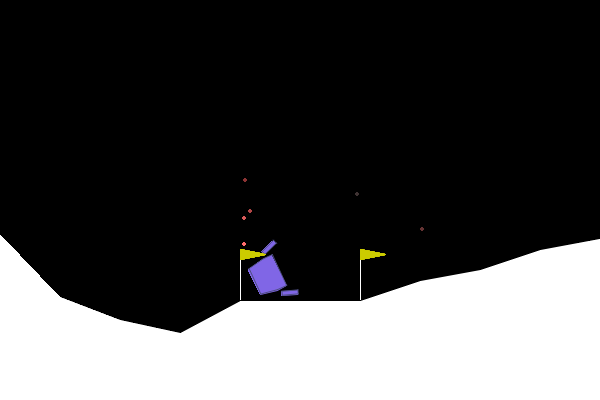

In [282]:
state, info = env.reset(seed=505)
for t in range(100):
    # clear frame
    display.clear_output(wait=True)
    
    action = agent.select_action(state)

    # render game
    frame = env.render()
    display.display(Image.fromarray(frame))
    time.sleep(0.05)

    state, reward, done, _, info = env.step(action)
    if done:
        break
        
env.close()

### 7. Train the Agent with DQN

In [283]:
def noisy_dueling_ddqn(
    env,
    agent,
    n_episodes=2000,
    window=100,
    max_t=1000,
):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    # list containing scores from each episode
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, n_episodes + 1):

        # get init state
        state, _ = env.reset()

        # run each episode
        total_reward = 0
        for t in range(max_t):
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break

        # save current episode total score
        scores.append(total_reward)

        # [Update] Remove decay epsilon since we don't use e-greedy policy to select action

        # Print episode stats
        if len(scores) > window:
            avg_score = np.mean(scores[-window:])
            if avg_score > max_avg_score:
                max_avg_score = avg_score

        newline = "\n" if i_episode % window == 0 else ""
        print(
            f"\rEpisode {i_episode}/{n_episodes} | Max Average Score: {max_avg_score:.2f}",
            end=newline,
        )

        if max_avg_score >= 200.0:
            print(
                f"\nEnvironment solved in {i_episode - 100:d} episodes!\tAverage Score: {max_avg_score:.2f}"
            )
            torch.save(agent.Q.state_dict(), "checkpoint.pth")
            break
    return scores


scores = noisy_dueling_ddqn(
    env,
    agent,
    n_episodes=2000,
    window=100,
    max_t=1500,
)

Episode 100/2000 | Max Average Score: -inf
Episode 200/2000 | Max Average Score: -157.36
Episode 300/2000 | Max Average Score: -91.910
Episode 400/2000 | Max Average Score: -8.533
Episode 500/2000 | Max Average Score: 144.97
Episode 600/2000 | Max Average Score: 148.26
Episode 700/2000 | Max Average Score: 148.26
Episode 800/2000 | Max Average Score: 148.26
Episode 900/2000 | Max Average Score: 148.26
Episode 1000/2000 | Max Average Score: 174.86
Episode 1092/2000 | Max Average Score: 202.75
Environment solved in 992 episodes!	Average Score: 202.75


0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
1087    198.048125
1088    198.223369
1089    198.522819
1090    198.533373
1091    202.751065
Length: 1092, dtype: float64

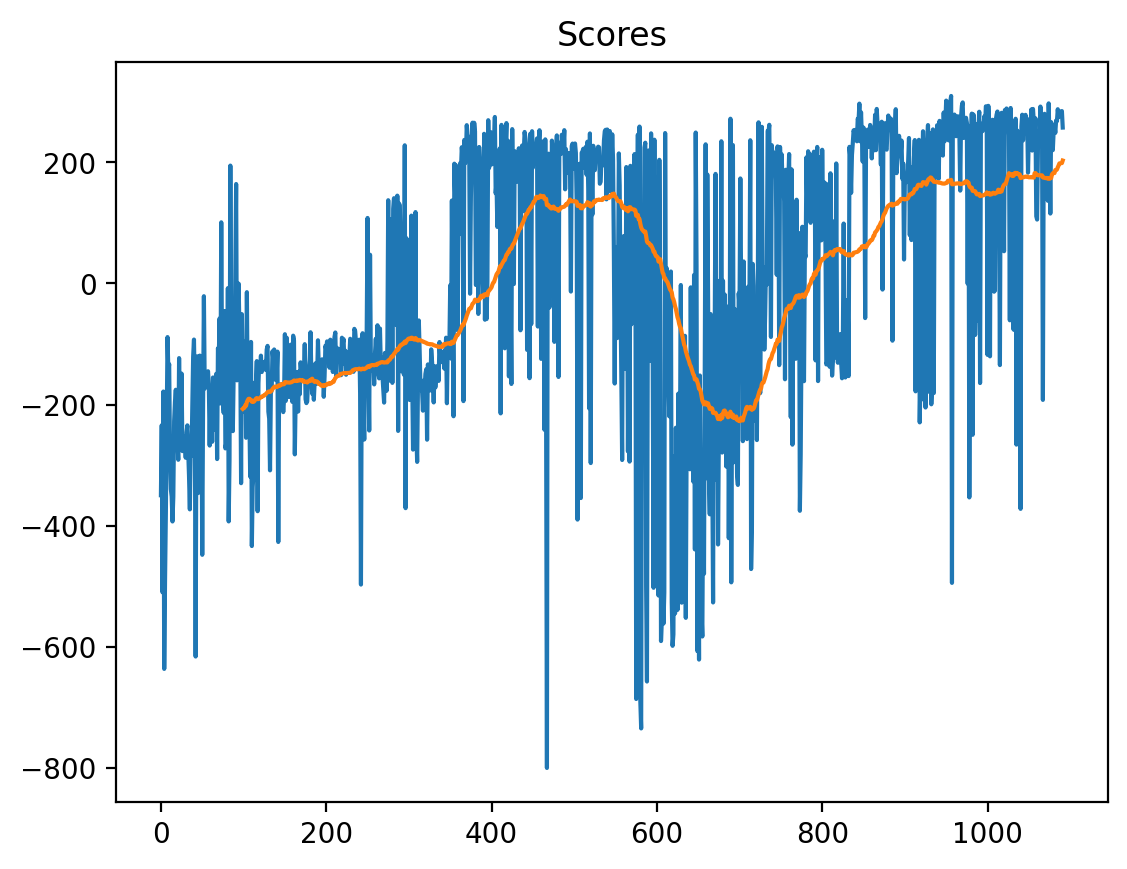

In [286]:
plot_scores(scores)

### 8. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

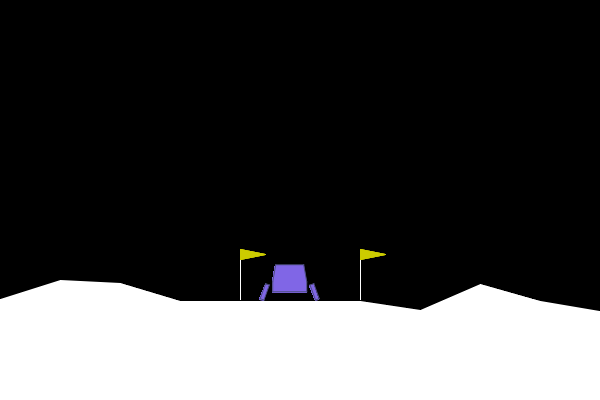

Final score: 264.7396435383321
Average score: 273.38461269721023


In [287]:
# load the weights from file
agent.Q.load_state_dict(torch.load('checkpoint.pth'))
agent.Q.eval() # deactivate noise
env = gym.make("LunarLander-v3", render_mode="rgb_array")

avg_score = 0
for i in range(3):
	state, info = env.reset()
	total_reward = 0
	for t in range(500):
		# clear frame
		display.clear_output(wait=True)

		action = agent.select_action(state)

		# render game
		frame = env.render()
		display.display(Image.fromarray(frame))
		time.sleep(0.05)

		state, reward, done, _, info = env.step(action)
		total_reward += reward
		if done:
			break
	
	avg_score += total_reward
	print('Final score:', total_reward)
env.close()
print(f"Average score: {avg_score / 3}")